In [54]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import patchify as pat
import cv2
import random
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models.detection import ssd300_vgg16
from torchvision.models.detection.ssd import SSDClassificationHead
from torch.utils.data import Dataset, DataLoader
import json
import os
from tqdm import tqdm


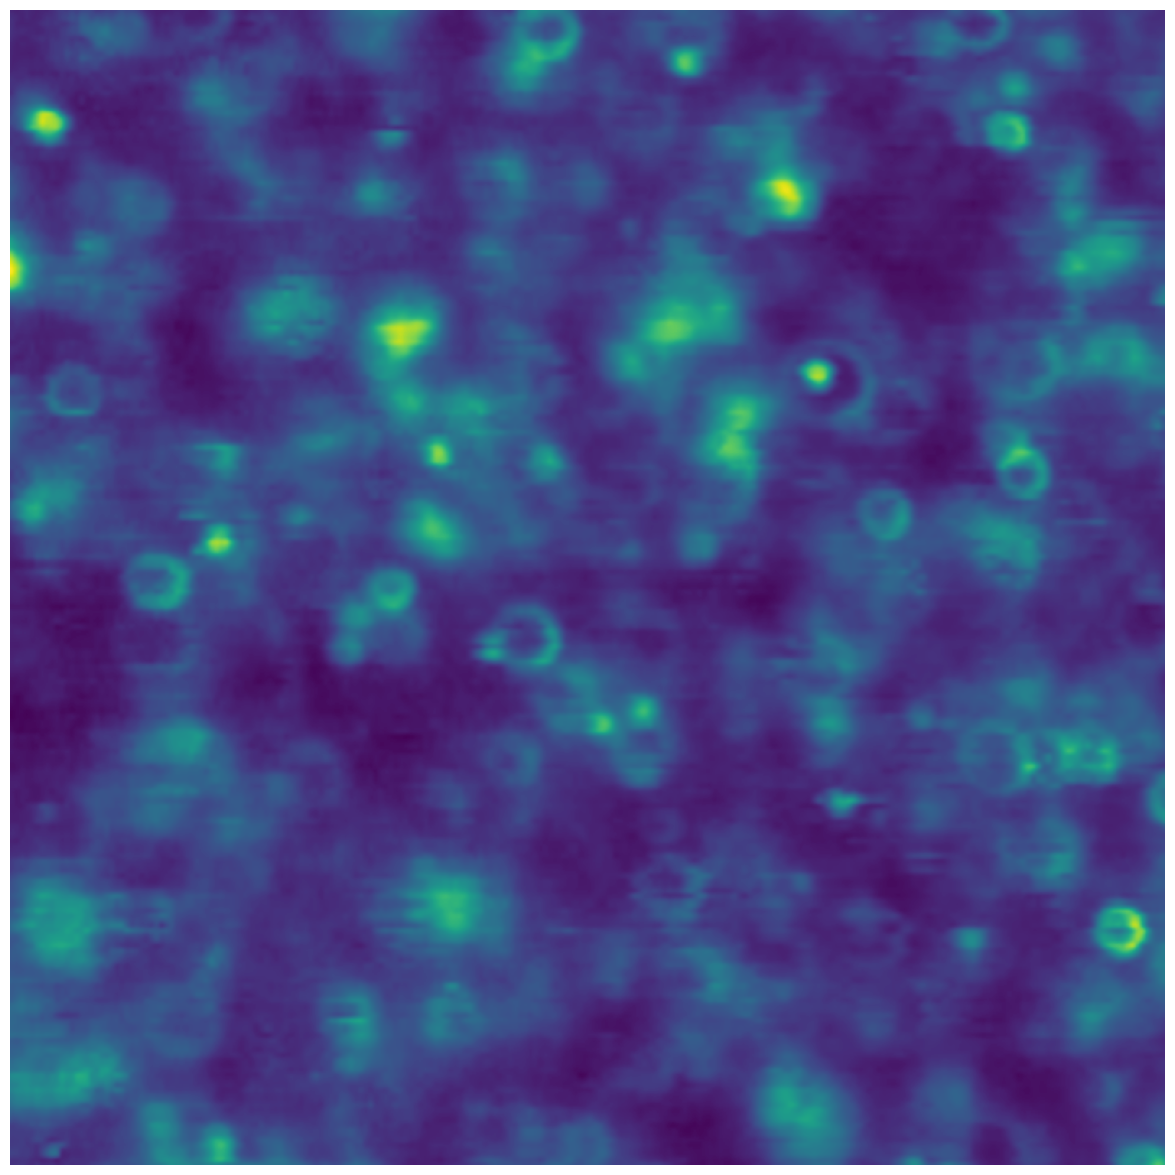

In [2]:

# Load the image using matplotlib
img = plt.imread("slsq_no_anneal.png")
img_gray = img[:800,:800,0]
plt.figure(figsize=(15,15))
plt.imshow(img_gray)
plt.axis("off")  # Turn off axis numbers and ticks
plt.show()

In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [4]:
# define the dataset class

# Custom dataset class for loading the synthetic data
class DonutDataset(Dataset):
    def __init__(self, images_file, annotations_file, transform=None, device = 'cpu'):
        self.images = np.load(images_file)
        with open(annotations_file, 'r') as f:
            self.annotations = json.load(f)
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Get image and convert to RGB (3 channels)
        img = self.images[idx]
        img = np.stack([img, img, img], axis=2)  # Convert grayscale to RGB
        
        # Get annotations for this image
        ann = next((a for a in self.annotations if a['image_id'] == idx), None)

        # Extract bounding box coordinates from potentially nested structure
        box_list = []
        for box in ann['boxes']:
            if isinstance(box, dict):
                # If each box is a dictionary, extract coordinates
                # This assumes each dict has x1, y1, x2, y2 or similar keys
                # Adjust these keys based on your actual data structure
                if all(k in box for k in ['x1', 'y1', 'x2', 'y2']):
                    box_list.append([box['x1'], box['y1'], box['x2'], box['y2']])
                # Alternative format with 'x', 'y', 'width', 'height'
                elif all(k in box for k in ['x', 'y', 'width', 'height']):
                    box_list.append([box['x'], box['y'], box['x'] + box['width'], box['y'] + box['height']])
            else:
                # If it's already a list, use it directly
                box_list.append(box)
        
        boxes = torch.tensor(box_list, dtype=torch.float32)
        
        # Create target dictionary
        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.ones((boxes.shape[0],), dtype=torch.int64)  # All boxes are donuts (class 1)
        
        # Convert image to tensor
        
        # max/min normalization
        img = (img - img.min()) / (img.max() - img.min())
        img = torch.from_numpy(img).permute(2, 0, 1).float()

        if self.transform:
            img = self.transform(img)
        
        return img, target, ann


In [5]:
# Function to convert dataset annotations to target tensors
def create_targets(images, annotations, output_size=(16, 16)):
    """
    Convert annotations to target tensors for training
    
    Args:
        images: Batch of images [B, C, H, W]
        annotations: List of dicts with 'boxes' key
        output_size: Size of the output feature map
    
    Returns:
        Dict with 'confidence' and 'boxes' tensors
    """
    batch_size = len(images)
    device = images.device
    
    # Initialize targets
    target_conf = torch.zeros(batch_size, 1, output_size[0], output_size[1], device=device)
    target_boxes = torch.zeros(batch_size, 4, output_size[0], output_size[1], device=device)
    
    # Get input image dimensions
    _, _, img_h, img_w = images.shape
    
    # Scale factors
    scale_x = output_size[1] / img_w
    scale_y = output_size[0] / img_h
    
   
    for b, ann in enumerate(annotations):
        # For each bounding box in the image
        for box in ann['boxes']:
            x1, y1, x2, y2 = box
            
            # Convert to center format
            cx = (x1 + x2) / 2
            cy = (y1 + y2) / 2
            w = x2 - x1
            h = y2 - y1
            
            # Scale to feature map coordinates
            cx_scaled = cx * scale_x
            cy_scaled = cy * scale_y
            
            # Get the grid cell where center falls
            grid_x = int(cx_scaled)
            grid_y = int(cy_scaled)
            
            # Only proceed if within bounds
            if 0 <= grid_x < output_size[1] and 0 <= grid_y < output_size[0]:
                # Set confidence to 1 at this location
                target_conf[b, 0, grid_y, grid_x] = 1.0
                
                # Set bounding box parameters (normalized to cell)
                target_boxes[b, 0, grid_y, grid_x] = cx_scaled - grid_x  # x offset in cell (0-1)
                target_boxes[b, 1, grid_y, grid_x] = cy_scaled - grid_y  # y offset in cell (0-1)
                target_boxes[b, 2, grid_y, grid_x] = w * scale_x / output_size[1]  # width relative to image
                target_boxes[b, 3, grid_y, grid_x] = h * scale_y / output_size[0]  # height relative to image
    
    return {'confidence': target_conf, 'boxes': target_boxes}


# Function for post-processing predictions
def decode_predictions(predictions, threshold=0.5, input_size=(512, 512)):
    """
    Decode network predictions to get bounding boxes
    
    Args:
        predictions: Dict with 'confidence' and 'boxes' from network
        threshold: Confidence threshold
        input_size: Original image size (height, width)
    
    Returns:
        List of dicts with 'boxes' and 'scores' for each image
    """
    batch_size = predictions['confidence'].shape[0]
    conf = torch.sigmoid(predictions['confidence'])
    boxes = predictions['boxes']
    
    # Get feature map size
    _, _, feat_h, feat_w = conf.shape
    
    # Scale factors to convert back to image coordinates
    scale_x = input_size[1] / feat_w
    scale_y = input_size[0] / feat_h
    
    results = []
    for b in range(batch_size):
        # Find locations above threshold
        locations = (conf[b, 0] > threshold).nonzero(as_tuple=True)
        grid_y, grid_x = locations
        
        # Get scores and box parameters for these locations
        scores = conf[b, 0, grid_y, grid_x]
        
        # If no detections, return empty results
        if len(scores) == 0:
            results.append({'boxes': torch.zeros((0, 4)), 'scores': torch.zeros(0)})
            continue
        
        # Get box parameters
        x_offset = boxes[b, 0, grid_y, grid_x]
        y_offset = boxes[b, 1, grid_y, grid_x]
        rel_width = boxes[b, 2, grid_y, grid_x]
        rel_height = boxes[b, 3, grid_y, grid_x]
        
        # Convert to image coordinates
        cx = (grid_x + x_offset) * scale_x
        cy = (grid_y + y_offset) * scale_y
        width = rel_width * input_size[1]
        height = rel_height * input_size[0]
        
        # Convert to [x1, y1, x2, y2] format
        x1 = cx - width / 2
        y1 = cy - height / 2
        x2 = cx + width / 2
        y2 = cy + height / 2
        
        # Clip to image boundaries
        x1 = torch.clamp(x1, 0, input_size[1]-1)
        y1 = torch.clamp(y1, 0, input_size[0]-1)
        x2 = torch.clamp(x2, 0, input_size[1]-1)
        y2 = torch.clamp(y2, 0, input_size[0]-1)
        
        # Stack into boxes tensor
        boxes_out = torch.stack([x1, y1, x2, y2], dim=1)
        
        results.append({'boxes': boxes_out, 'scores': scores})
    
    return results

In [6]:
class MultiDonutDetector(nn.Module):
    def __init__(self, num_classes=1):
        super(MultiDonutDetector, self).__init__()
        
        # Use MobileNetV2 as the backbone (lightweight for CPU training)
        backbone = torchvision.models.mobilenet_v2(pretrained=True).features
        
        # Extract intermediate features at different scales
        self.layer1 = backbone[:2]   # 1/2 resolution
        self.layer2 = backbone[2:4]  # 1/4 resolution
        self.layer3 = backbone[4:7]  # 1/8 resolution
        self.layer4 = backbone[7:14] # 1/16 resolution
        self.layer5 = backbone[14:]  # 1/32 resolution
        
        # Prediction heads - keeping the network simple
        self.conf_head = nn.Conv2d(1280, 1, kernel_size=1)  # Object confidence
        self.bbox_head = nn.Conv2d(1280, 4, kernel_size=1)  # bounding box (x,y,w,h)
        
    def forward(self, x):
        # Feature extraction
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        features = self.layer5(x4)
        
        # Make predictions
        confidence = self.conf_head(features)
        bboxes = self.bbox_head(features)
        
        return {
            'confidence': confidence,  # Shape: [batch, 1, H/32, W/32]
            'boxes': bboxes            # Shape: [batch, 4, H/32, W/32]
        }

In [7]:
# Custom loss function
class MultiDonutLoss(nn.Module):
    def __init__(self, lambda_conf=1.0, lambda_bbox=1.0):
        super(MultiDonutLoss, self).__init__()
        self.lambda_conf = lambda_conf
        self.lambda_bbox = lambda_bbox
        
    def forward(self, predictions, targets):
        pred_conf = predictions['confidence']
        pred_boxes = predictions['boxes']
        
        target_conf = targets['confidence']  # [batch, 1, H/32, W/32]
        target_boxes = targets['boxes']      # [batch, 4, H/32, W/32] 
        
        # Binary cross entropy for confidence
        conf_loss = F.binary_cross_entropy_with_logits(pred_conf, target_conf)
        
        # L1 loss for bounding boxes (only where objects exist)
        # We first create a mask from target_conf to focus on cells with objects
        pos_mask = (target_conf > 0.5).float()
        bbox_loss = F.smooth_l1_loss(pred_boxes * pos_mask.repeat(1, 4, 1, 1), 
                                    target_boxes * pos_mask.repeat(1, 4, 1, 1),
                                    reduction='sum')
        
        # Normalize by number of positive cells
        num_pos = torch.max(pos_mask.sum(), torch.tensor(1.0).to(pos_mask.device))
        bbox_loss = bbox_loss / num_pos
        
        # Total loss
        total_loss = self.lambda_conf * conf_loss + self.lambda_bbox * bbox_loss
        
        return total_loss, {'conf_loss': conf_loss, 'bbox_loss': bbox_loss}


In [108]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10, save_path='models_for_SLSQ/donut_detector_best.pth'):
    model.to(device)
    
    loss_history = []
    val_loss_history = []
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            # Unpack the batch
            images, target, annotations = batch
            
            # For nested tuple structures, handle differently
            if isinstance(images, tuple):
                images = torch.stack(images)
            
            # Move data to device
            images = images.to(device)
            
            # Create target tensors
            targets = create_targets(images, target, output_size=(16, 16))
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(images)
            
            # Calculate loss
            loss, loss_components = criterion(predictions, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Calculate average training loss for this epoch
        avg_train_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                # Unpack the batch
                images, target, annotations = batch
                
                if isinstance(images, tuple):
                    images = torch.stack(images)
                
                # Move data to device
                images = images.to(device)
                
                # Create target tensors
                targets = create_targets(images, target, output_size=(16, 16))
                
                # Forward pass
                predictions = model(images)
                
                # Calculate loss
                loss, _ = criterion(predictions, targets)
                val_loss += loss.item()
        
        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)
        
        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Save model if validation loss improved
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Validation loss improved to {avg_val_loss:.4f}. Model saved to '{save_path}'")
    
    print(f"Best validation loss: {best_val_loss:.4f}")
    return loss_history, val_loss_history

In [8]:
# Function to evaluate the model
def evaluate_model(model, data_loader, device, num_preds=10):
    model.eval()
    
    with torch.no_grad():
        # Choose a random batch to visualize
        batch_idx = random.randint(0, len(data_loader)-1)

        for batch in tqdm(data_loader):
            # Unpack the batch - this is the critical fix
            images, target, annotations = batch
                   
            # For nested tuple structures, we need to handle differently
            if isinstance(images, tuple):
                # Convert tuple of images to tensor batch
                images = torch.stack(images)
            
            # Move data to device
            images = images.to(device)

            # Forward pass
            predictions = model(images)
            
            # decode predictions
            decoded_predictions = decode_predictions(predictions)
            
            # visualise prediction from n outputs
            for i in range(num_preds):
                visualise(images[i], decoded_predictions[i])
            break

    

In [103]:
# Create directories if they don't exist
os.makedirs('models_for_SLSQ', exist_ok=True)

In [22]:
# Create datasets and dataloaders
train_dataset = DonutDataset(
    'synthetic_data_2/numpy_arrays/train_images.npy',
    'synthetic_data_2/annotations/train_annotations.json'
)

val_dataset = DonutDataset(
    'synthetic_data_2/numpy_arrays/val_images.npy',
    'synthetic_data_2/annotations/val_annotations.json'
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=lambda batch: tuple(zip(*batch))  # Required for detection models
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=lambda batch: tuple(zip(*batch))
)



In [68]:
def visualise(img, ann, prediction=False):
    '''
    Visualise an img+annotation.
    If prediction = False, then the annotations are ground truth. Used only for labelling.
    '''
    

    plt.figure(figsize=(10,10))
    plt.imshow(img[0,:,:], cmap='gray')
    if prediction:
        plt.title('Ground truths')
    else:
        plt.title('Model prediction')
    
   
    donut_boxes = ann['boxes']
   # print(donut_boxes)
   # print(ann['scores'])
    # Draw bounding boxes
    for box in donut_boxes:
        # Create rectangle patch
        x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
        width = x2 - x1
        height = y2 - y1
        
        # Draw rectangle
        rect = plt.Rectangle((x1, y1), width, height, 
                            fill=False, edgecolor='red', linewidth=1)
       # plt.gca().add_patch(rect)
        
        # Optionally, draw center point
        #plt.plot(box['center_x'], box['center_y'], 'r+')

    plt.title(f'Synthetic Image with Donut Bounding Boxes ({len(donut_boxes)} donuts)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Print bounding box information for first 5 donuts
    for i, box in enumerate(donut_boxes[:5]):
        print(f"Donut {i+1}:")
        print(f"  Bounding box: ({box[0]}, {box[1]}) to ({box[2]}, {box[3]})")
        #print(f"  Center: ({box['center_x']}, {box['center_y']})")
        #print(f"  Outer radius: {box['outer_radius']}, Inner radius: {box['inner_radius']}")

  0%|          | 0/75 [00:00<?, ?it/s]

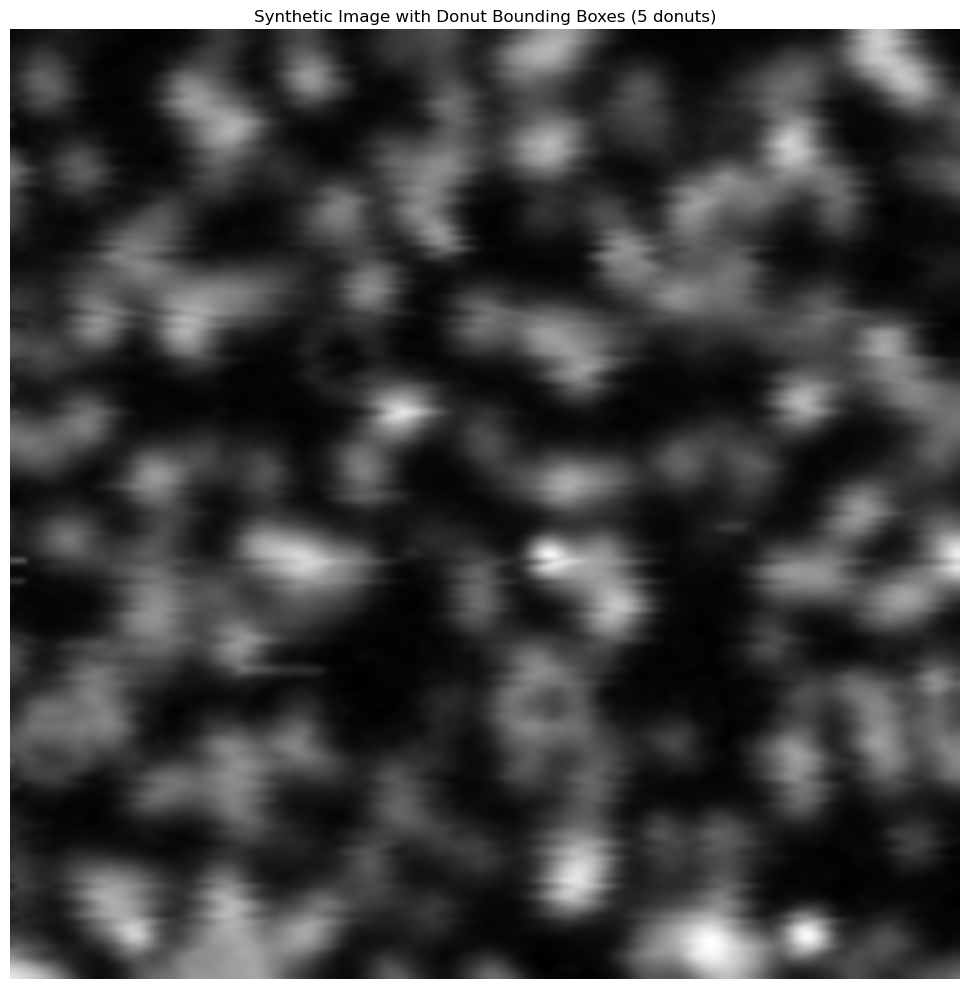

Donut 1:
  Bounding box: (321.5498962402344, 119.05889129638672) to (351.4675598144531, 149.5924835205078)
Donut 2:
  Bounding box: (163.360595703125, 162.74676513671875) to (199.66400146484375, 198.82177734375)
Donut 3:
  Bounding box: (287.7945861816406, 352.4378967285156) to (314.6879577636719, 380.4340515136719)
Donut 4:
  Bounding box: (368.6473083496094, 371.5474548339844) to (387.3487854003906, 390.1895446777344)
Donut 5:
  Bounding box: (7.746013641357422, 372.2915954589844) to (36.94371795654297, 401.6416931152344)


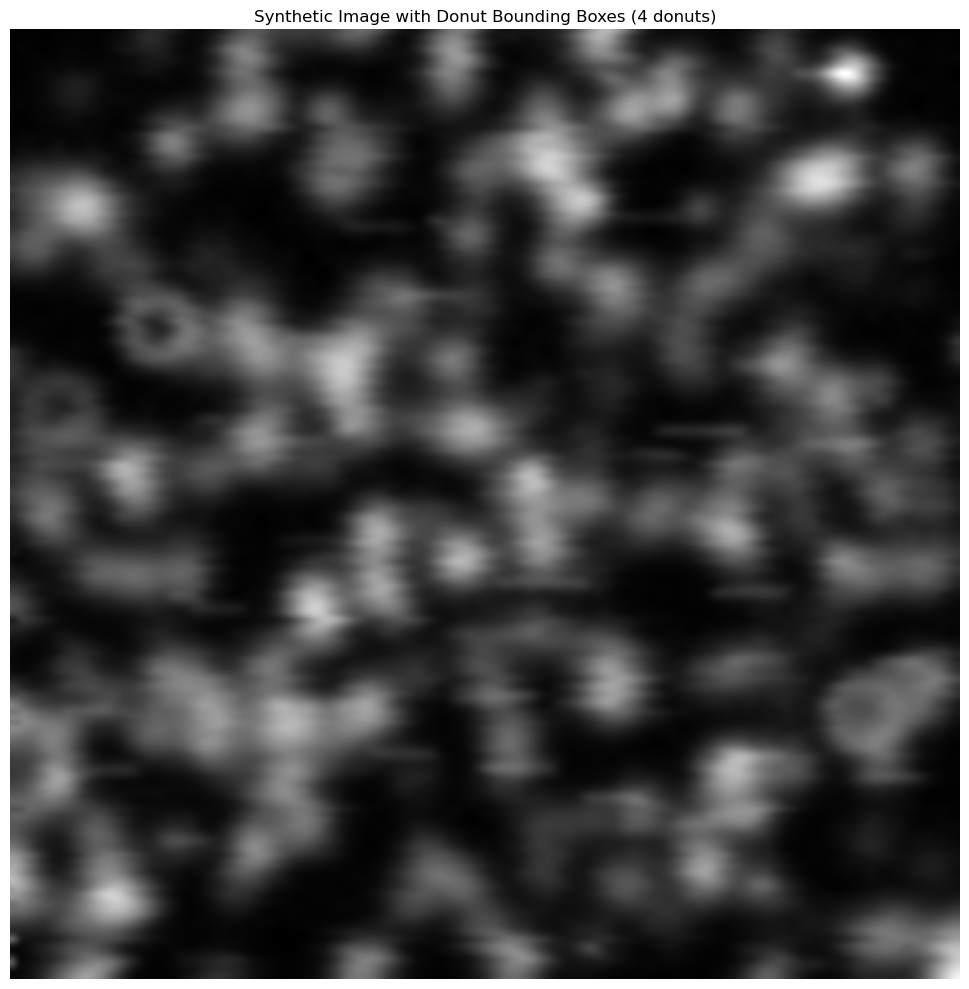

Donut 1:
  Bounding box: (64.48310852050781, 147.07635498046875) to (98.66372680664062, 181.60543823242188)
Donut 2:
  Bounding box: (13.396307945251465, 195.86293029785156) to (41.815696716308594, 224.9153594970703)
Donut 3:
  Bounding box: (444.02008056640625, 353.03009033203125) to (481.69879150390625, 390.10498046875)
Donut 4:
  Bounding box: (474.4854736328125, 346.2292785644531) to (498.29833984375, 372.1031188964844)


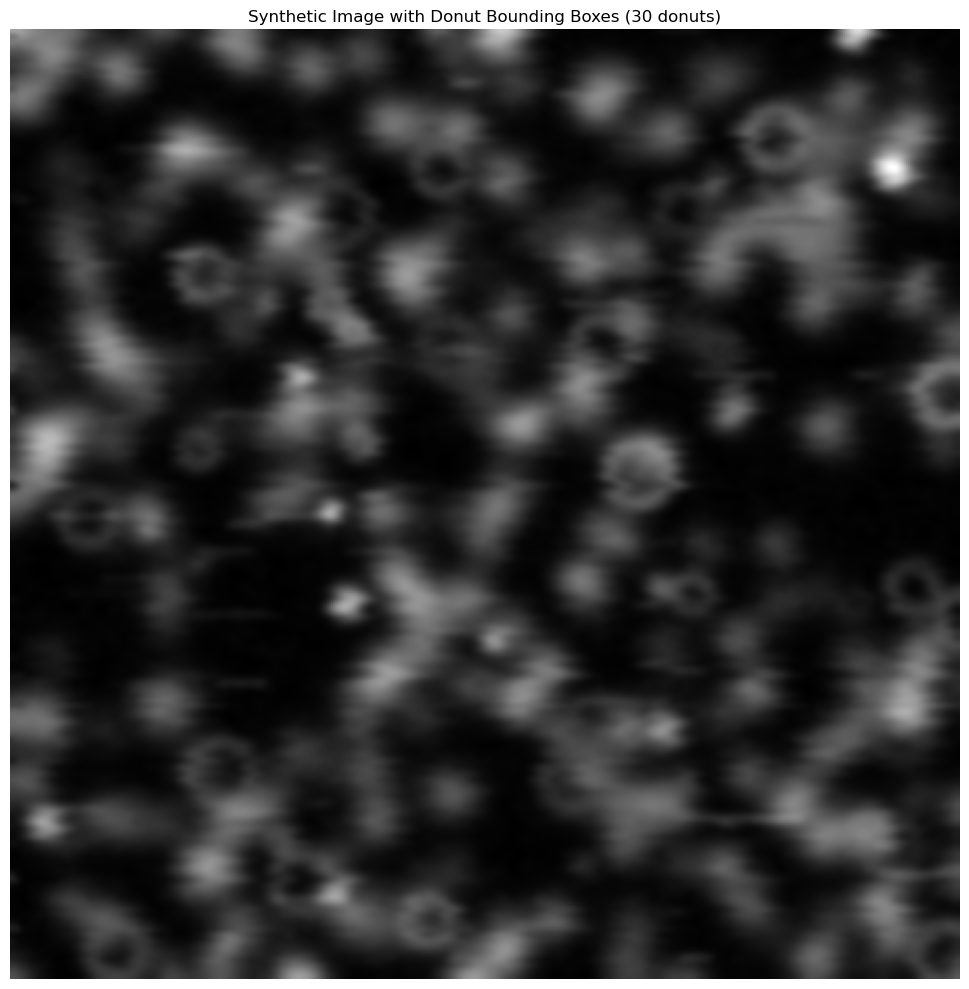

Donut 1:
  Bounding box: (4.8688459396362305, 9.529184341430664) to (28.357746124267578, 31.13780403137207)
Donut 2:
  Bounding box: (230.0030517578125, 4.621259689331055) to (256.3121337890625, 29.01578712463379)
Donut 3:
  Bounding box: (405.3421325683594, 51.49180603027344) to (432.7292175292969, 78.60496520996094)
Donut 4:
  Bounding box: (32.936763763427734, 79.78568267822266) to (62.56050491333008, 107.4972915649414)
Donut 5:
  Bounding box: (216.8507843017578, 62.83249282836914) to (249.5319061279297, 95.430419921875)


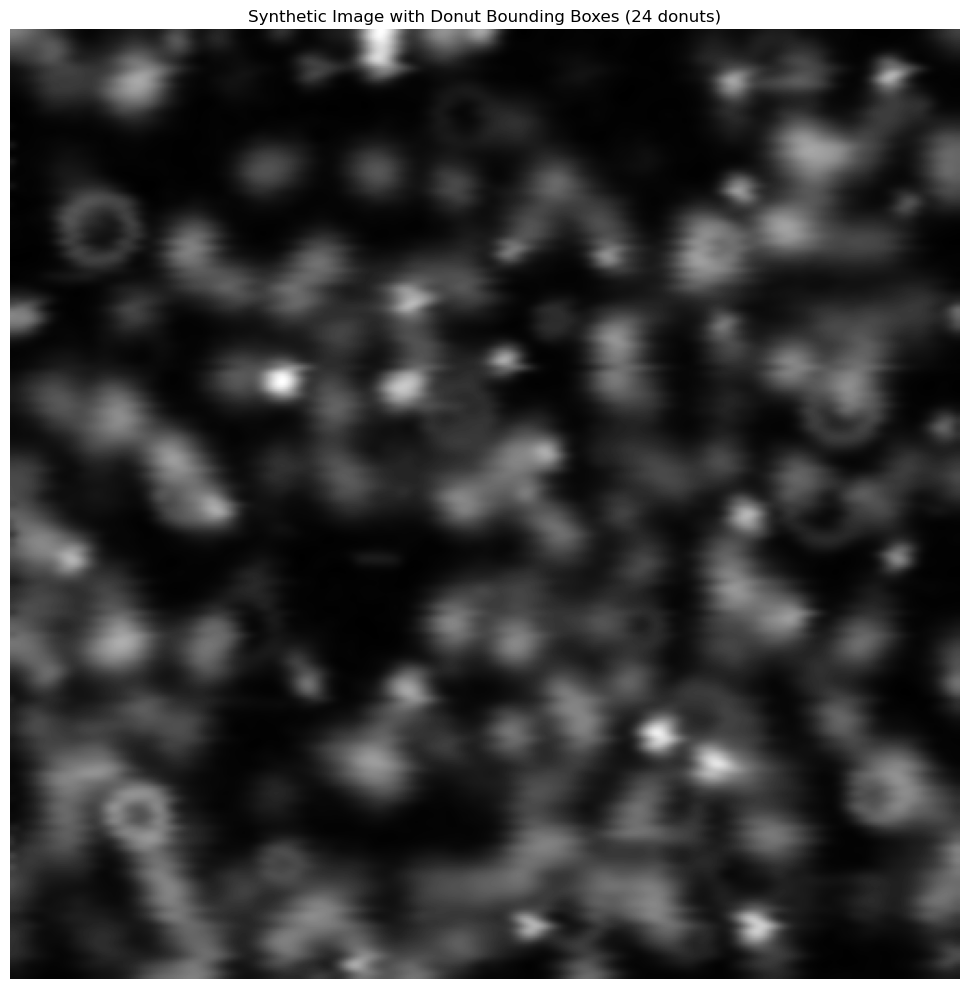

Donut 1:
  Bounding box: (161.08096313476562, 11.269702911376953) to (185.63485717773438, 33.57157516479492)
Donut 2:
  Bounding box: (388.830078125, 4.568781852722168) to (411.7734375, 28.26403045654297)
Donut 3:
  Bounding box: (409.76641845703125, 10.23714828491211) to (438.65606689453125, 38.98886489868164)
Donut 4:
  Bounding box: (229.9934539794922, 36.013832092285156) to (264.51708984375, 69.67127227783203)
Donut 5:
  Bounding box: (35.618064880371094, 93.932373046875) to (68.9500961303711, 126.03863525390625)


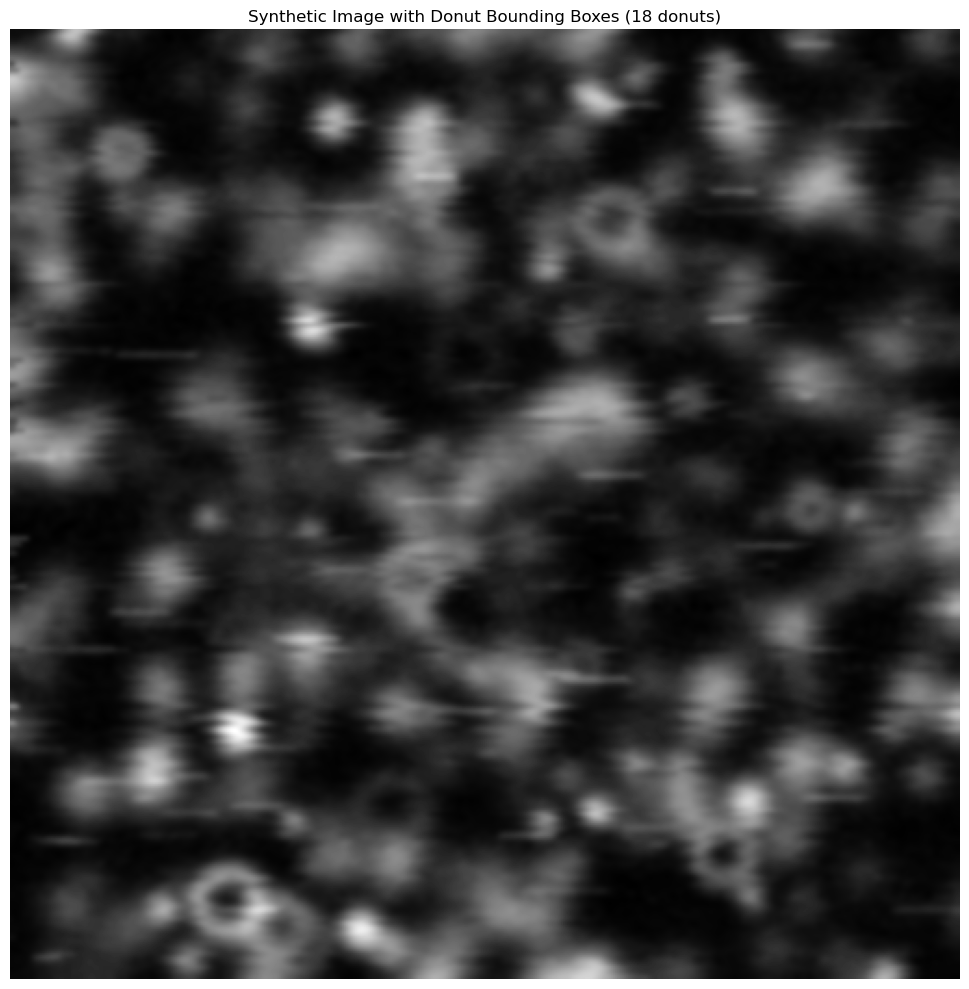

Donut 1:
  Bounding box: (43.624908447265625, 56.495765686035156) to (76.89523315429688, 88.8495101928711)
Donut 2:
  Bounding box: (0.8128890991210938, 97.67300415039062) to (24.469751358032227, 123.53413391113281)
Donut 3:
  Bounding box: (307.7424011230469, 92.276611328125) to (339.8656921386719, 124.50820922851562)
Donut 4:
  Bounding box: (229.6156768798828, 166.08859252929688) to (262.388427734375, 198.14974975585938)
Donut 5:
  Bounding box: (294.3119201660156, 150.9040985107422) to (326.4763488769531, 183.27980041503906)


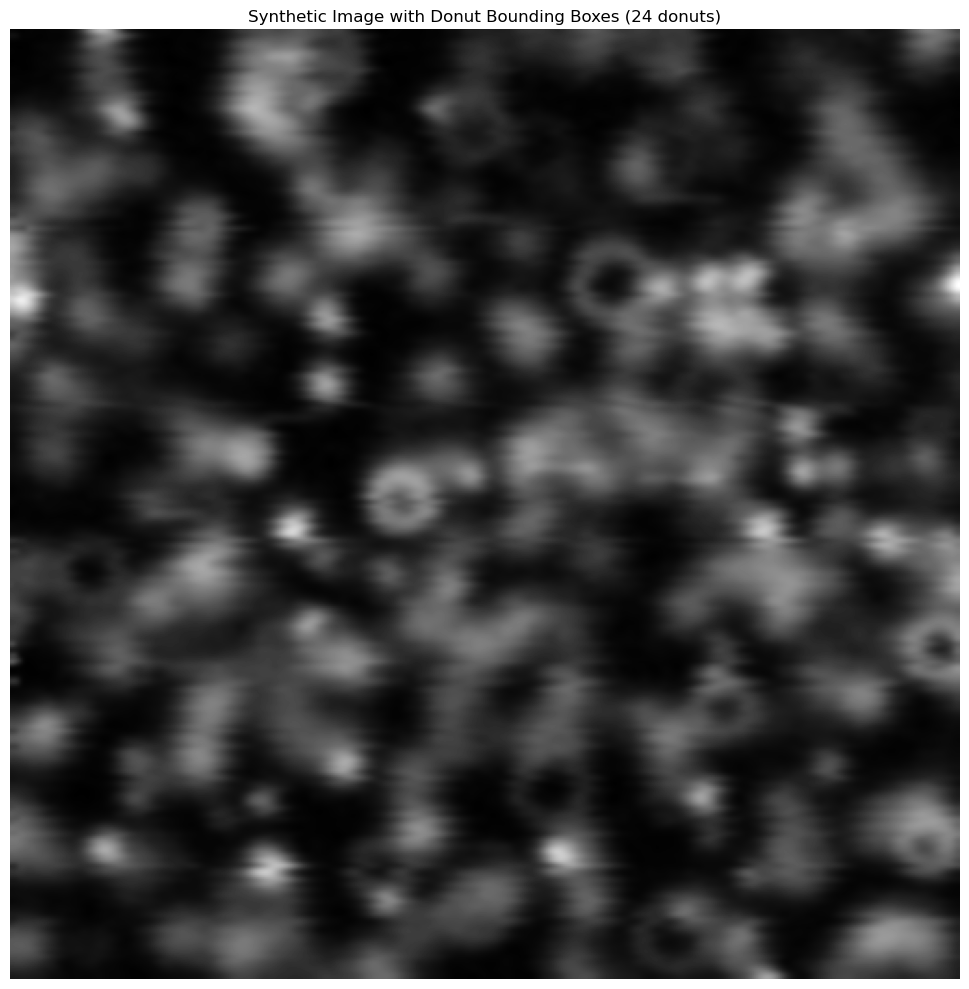

Donut 1:
  Bounding box: (156.12586975097656, 4.5038347244262695) to (188.8184051513672, 35.068397521972656)
Donut 2:
  Bounding box: (330.26348876953125, 0.0) to (359.4970703125, 22.456031799316406)
Donut 3:
  Bounding box: (341.74560546875, 0.1305408477783203) to (370.15399169921875, 26.222959518432617)
Donut 4:
  Bounding box: (230.0534210205078, 41.209617614746094) to (263.1146240234375, 74.12604522705078)
Donut 5:
  Bounding box: (258.2122802734375, 63.5869255065918) to (285.69140625, 91.37158203125)


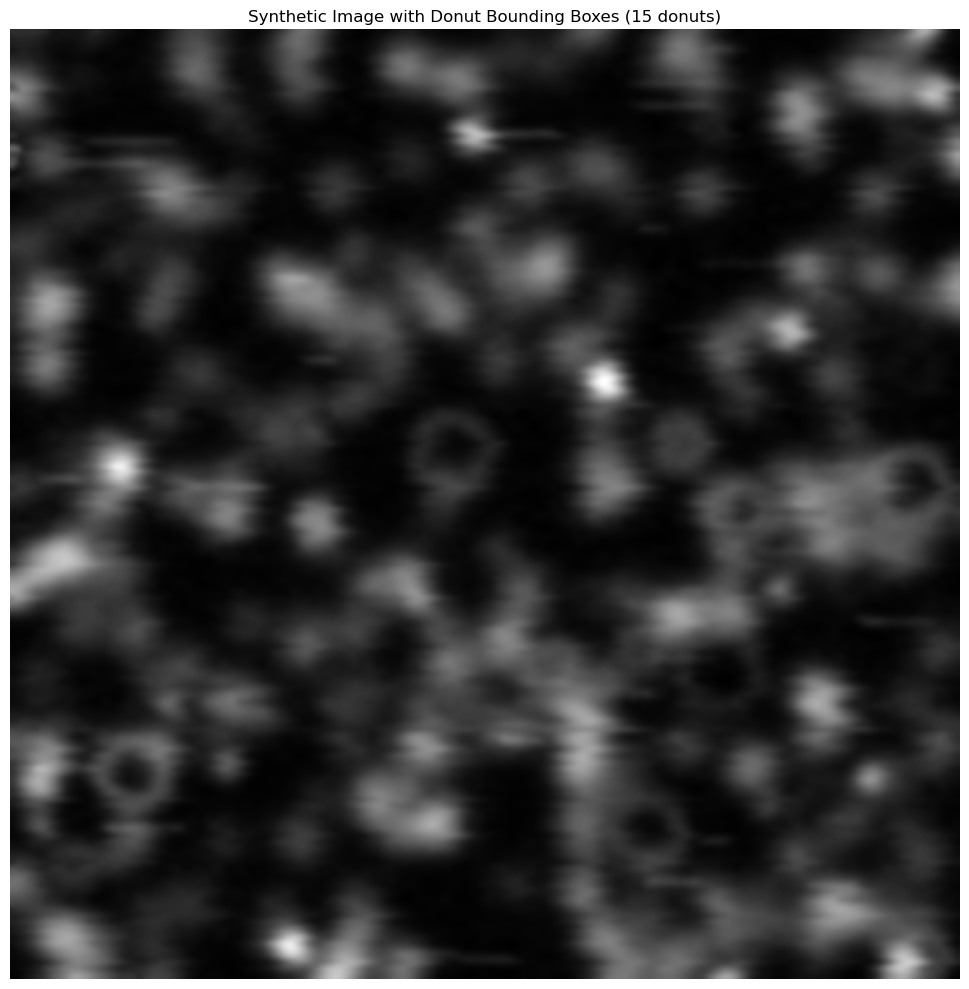

Donut 1:
  Bounding box: (473.7083740234375, 169.139404296875) to (506.91217041015625, 203.31976318359375)
Donut 2:
  Bounding box: (221.0844268798828, 216.12921142578125) to (258.3167724609375, 252.8074951171875)
Donut 3:
  Bounding box: (347.26727294921875, 210.78045654296875) to (380.790283203125, 243.178955078125)
Donut 4:
  Bounding box: (468.6615295410156, 231.82266235351562) to (504.3200378417969, 267.6258850097656)
Donut 5:
  Bounding box: (156.57728576660156, 256.97137451171875) to (178.15028381347656, 276.3447265625)


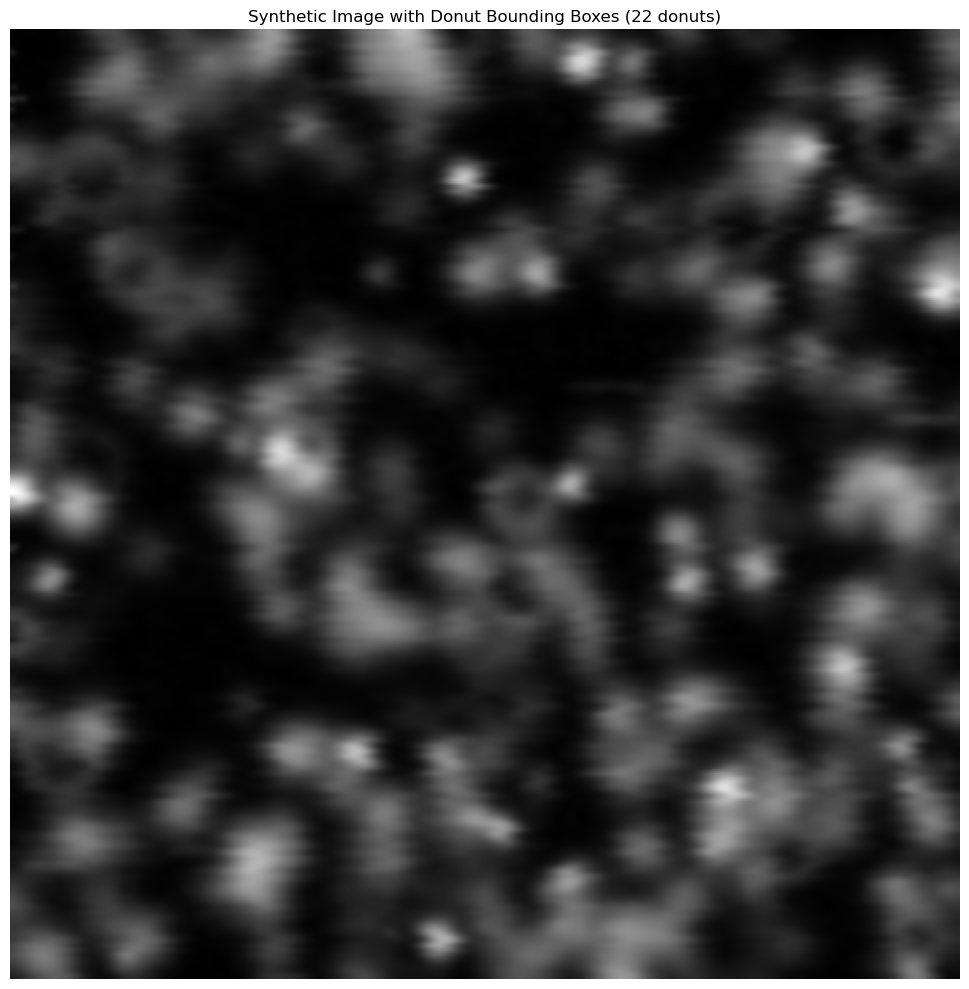

  0%|          | 0/75 [00:06<?, ?it/s]

Donut 1:
  Bounding box: (229.1908721923828, 0.0) to (259.1651916503906, 27.470935821533203)
Donut 2:
  Bounding box: (392.68927001953125, 0.0) to (419.7191162109375, 18.550498962402344)
Donut 3:
  Bounding box: (135.53018188476562, 29.21131134033203) to (162.1280517578125, 52.81011962890625)
Donut 4:
  Bounding box: (33.19484329223633, 71.49203491210938) to (64.16653442382812, 102.38079833984375)
Donut 5:
  Bounding box: (468.9375305175781, 53.288551330566406) to (502.4238586425781, 86.4503402709961)


IndexError: index 8 is out of bounds for dimension 0 with size 8

In [69]:
evaluate_model(model, val_loader, device)

In [ ]:
# Prepare the image for input to the model
def preprocess_image(image, device, output_size=512):
    # Convert grayscale image to RGB by repeating it for 3 channels
    if len(image.shape) == 2:
        img = np.stack([image, image, image], axis=2)
    else:
        img = image
        
    # Convert to tensor and normalize
    img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
    
    # Add batch dimension
    img_tensor = img_tensor.unsqueeze(0).to(device)
    
    # max/min normalization
    img_tensor = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min())

    # change to (512,512) like in training
    img_tensor = F.interpolate(img_tensor, size=(output_size, output_size), mode='bilinear', align_corners=False)

    return img_tensor


In [55]:
# Function to draw predictions on the image
def visualize_predictions(image, predictions, threshold=0.5, with_probs=True):
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(20, 20))

    # if image is tensor change to np array
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()[0,0,:,:]
    
    # If grayscale image (2D), show as is
    if len(image.shape) == 2:
        axes[0].imshow(image, cmap='gray')
    else:
        # If RGB image (3D), show it
        axes[0].imshow(image)
        
    # Get boxes with scores above threshold
    boxes = predictions['boxes']
    scores = predictions['scores']
    
    if len(scores) > 0:
        # Filter by threshold
        mask = scores >= threshold
        filtered_boxes = boxes[mask]
        filtered_scores = scores[mask]
        
        print(f"Found {len(filtered_boxes)} donuts with confidence > {threshold}")
        
        # Draw boxes
        for i, (box, score) in enumerate(zip(filtered_boxes, filtered_scores)):
            x1, y1, x2, y2 = box.cpu().numpy()
            width = x2 - x1
            height = y2 - y1
            
            # Create rectangle patch
            rect = Rectangle((x1, y1), width, height, 
                             fill=False, edgecolor='red', linewidth=2)
            axes[0].add_patch(rect)
            
            # Display score
            if with_probs:
                axes[0].text(x1, y1-5, f"{score.item():.2f}", 
                        fontsize=12, color='red', backgroundcolor='white')
    else:
        print("No donuts detected")
            
    axes[1].imshow(image, cmap='gray')
    axes[1].set_title("SLSQ image")
    axes[0].set_title("Donut Detection on SLSQ Image", fontsize=16)
    axes[0].axis("off")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

input res:  512
Found 70 donuts with confidence > 0.5


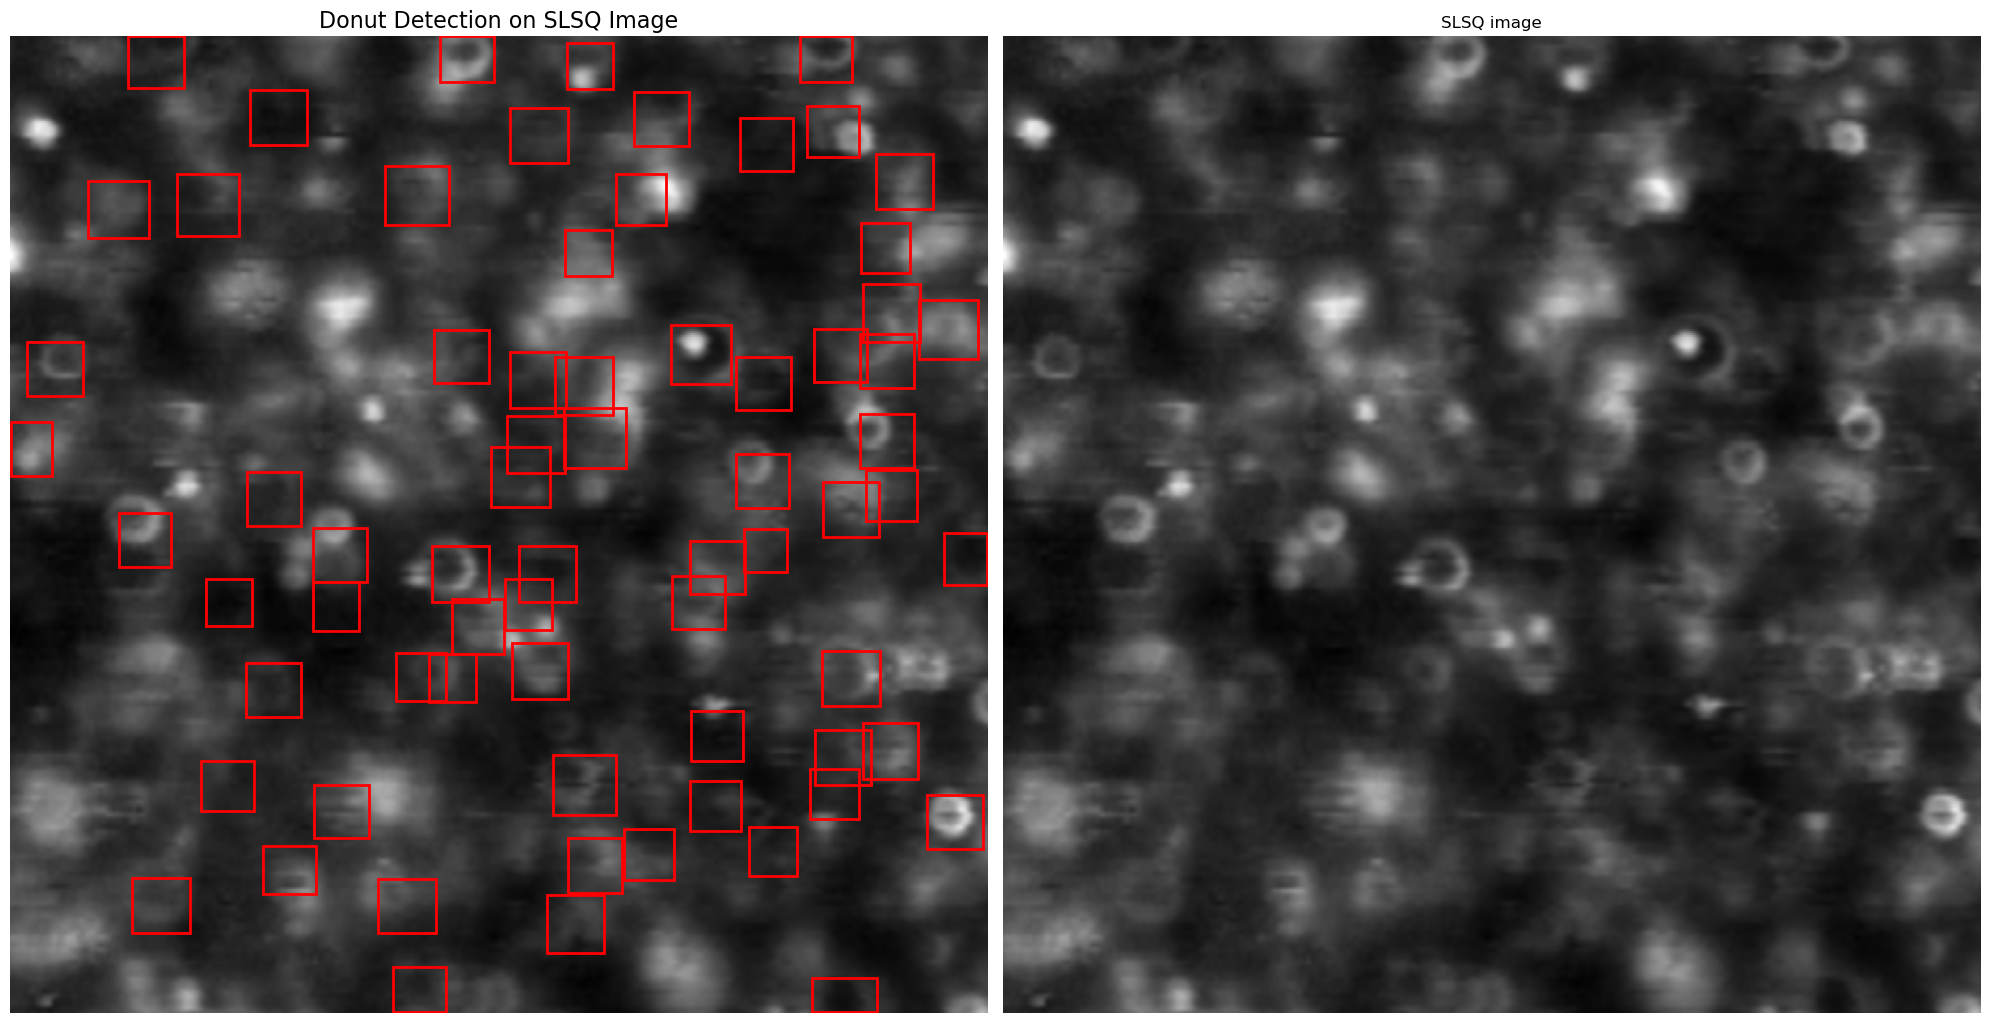

input res:  800
Found 70 donuts with confidence > 0.5


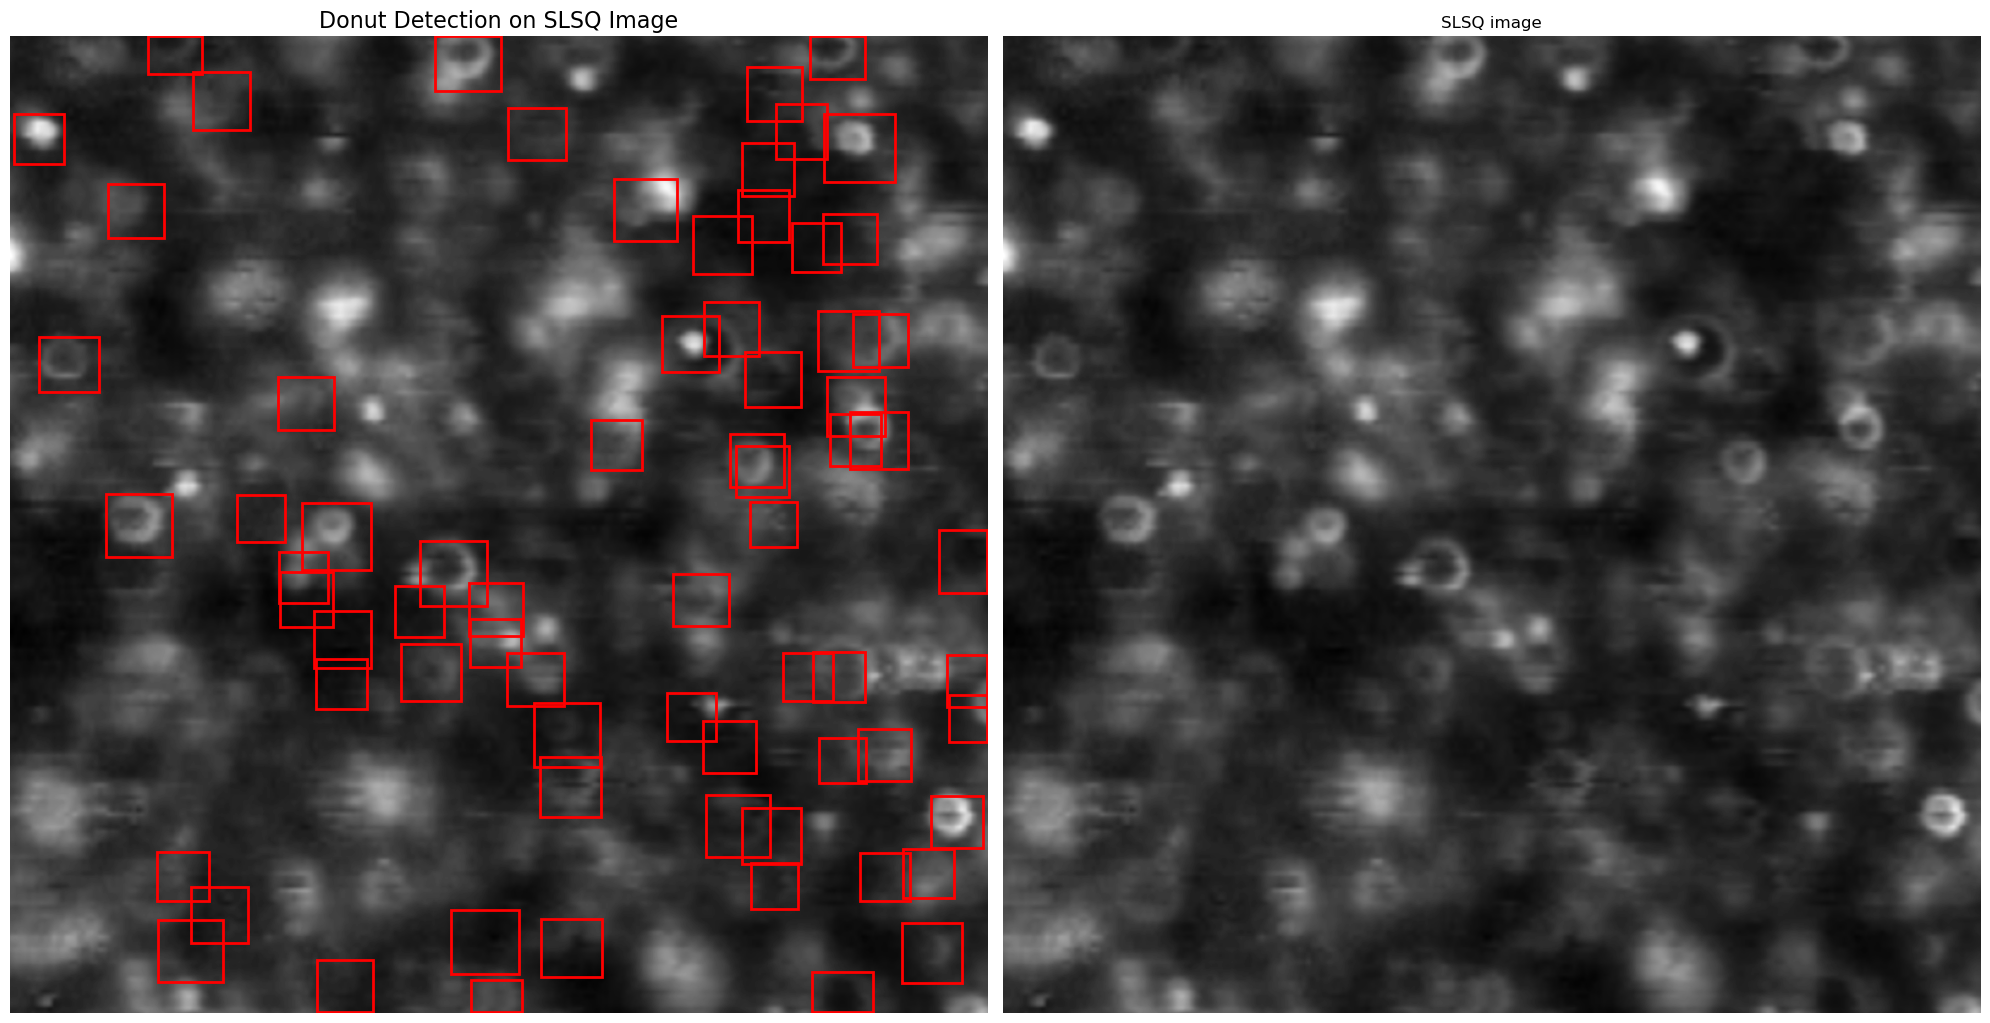

input res:  1100
Found 151 donuts with confidence > 0.5


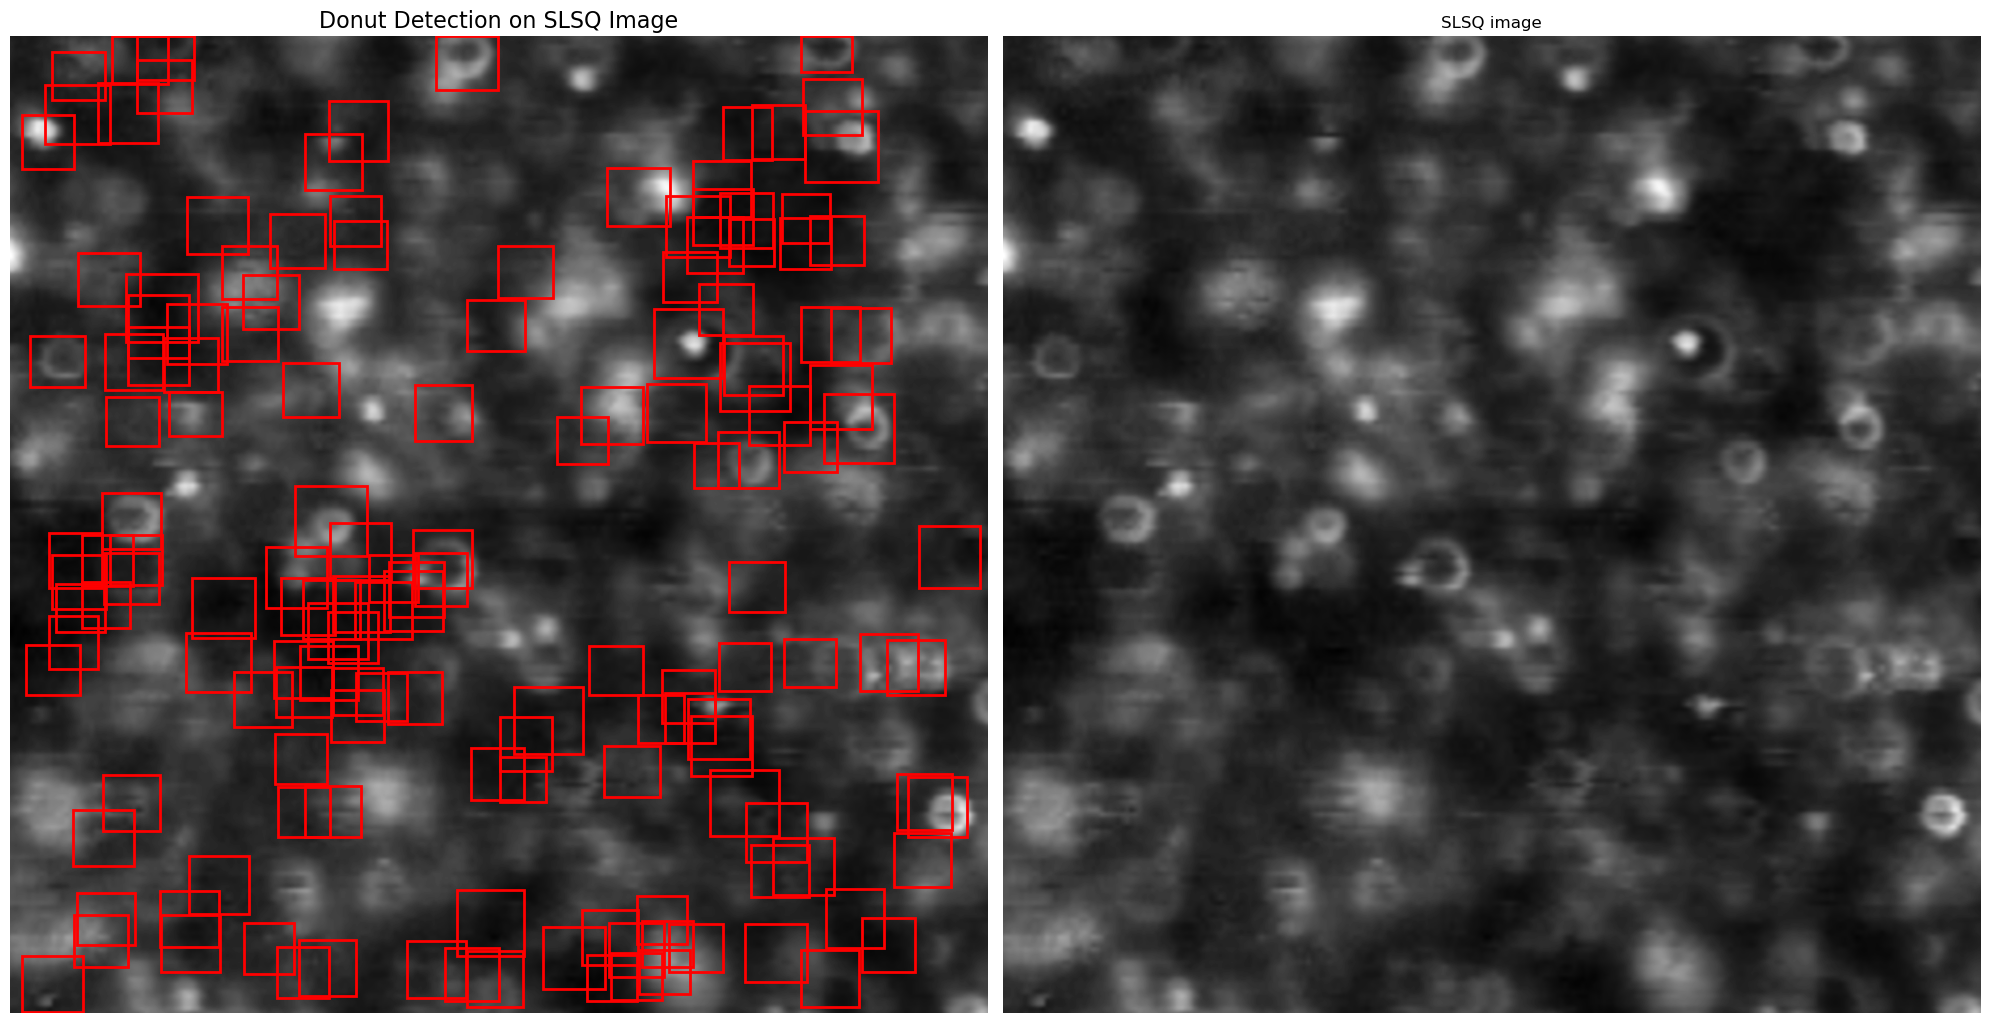

Found 168 donuts with confidence > 0.5


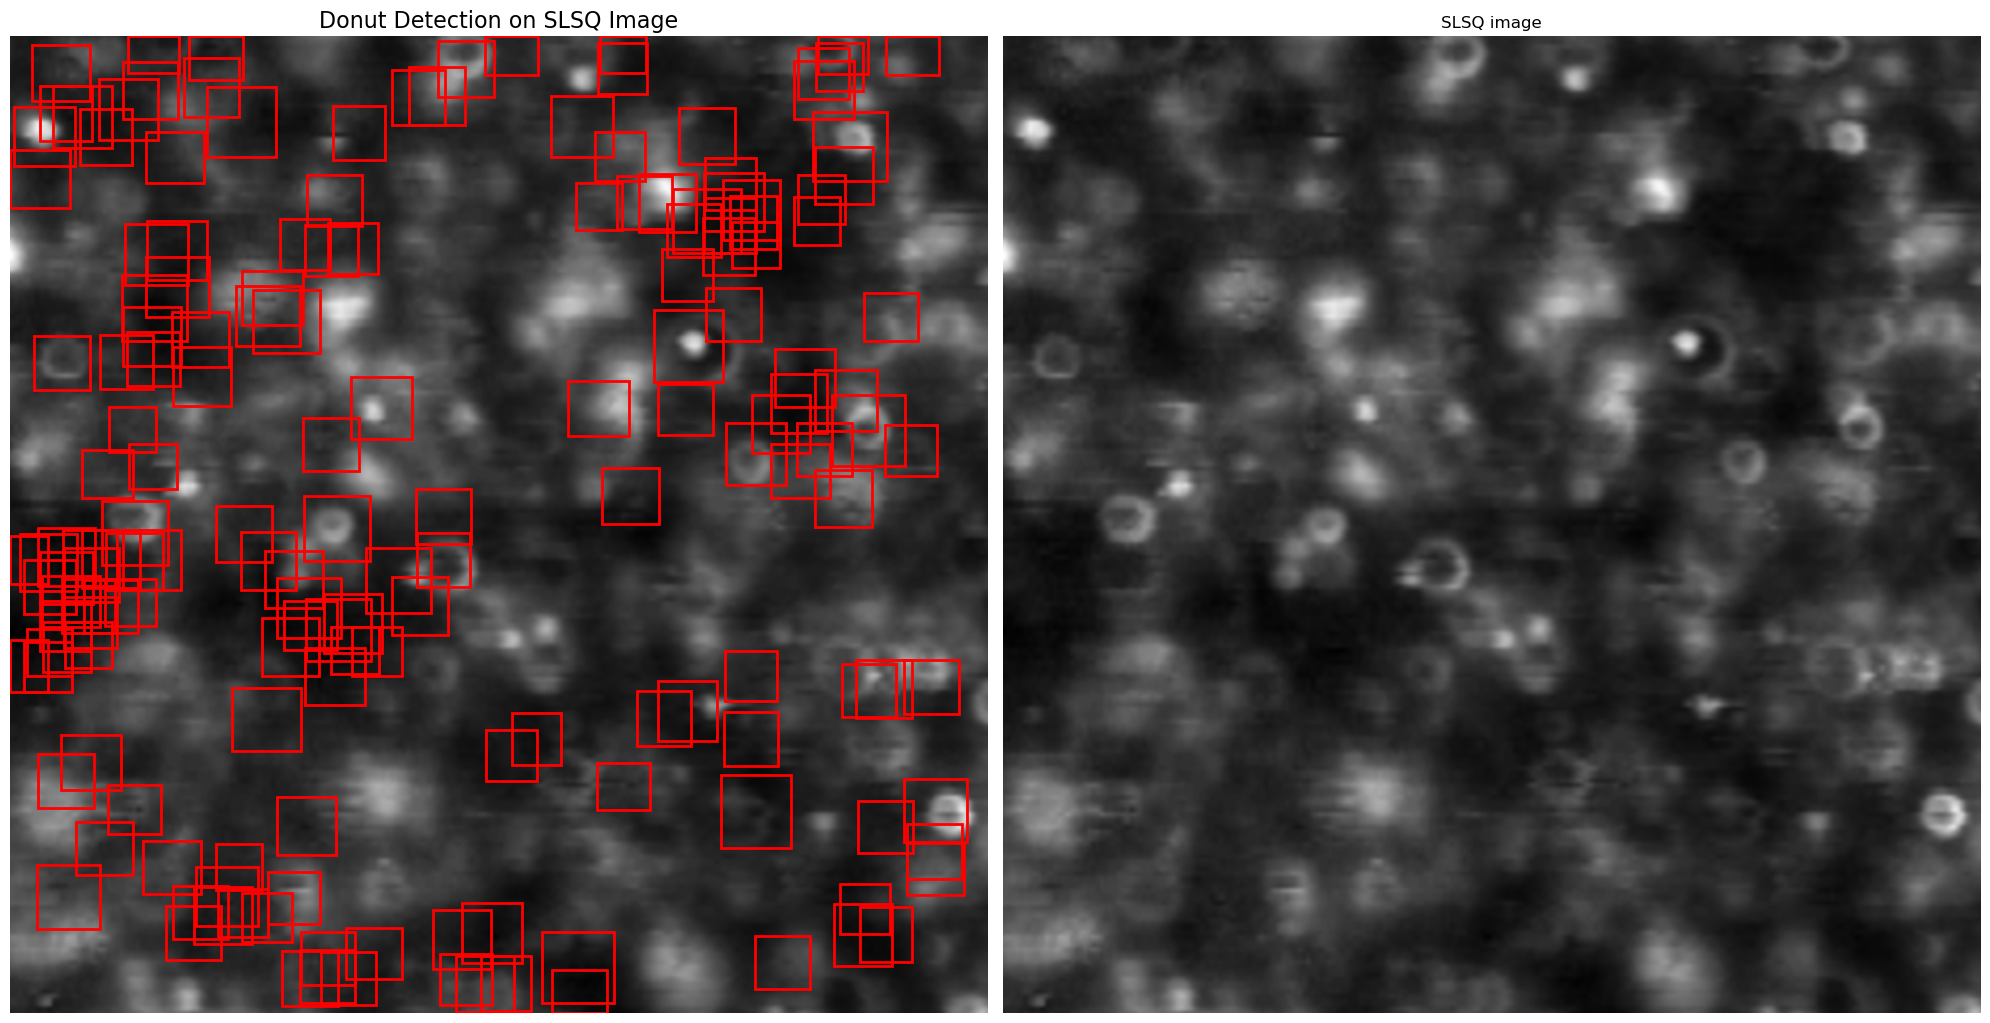

In [63]:
# Set model to evaluation mode
model.eval()


# Process the img_gray
out_res=512
img_tensor = preprocess_image(img_gray.copy(), device, output_size=out_res)

print('input res: ', out_res)

# Run inference
with torch.no_grad():
    predictions = model(img_tensor)
    
    # Set confidence threshold
    thr = 0.5
    
    res = img_tensor.shape[-1]

    # Decode predictions to get boxes in image coordinates
    decoded_preds = decode_predictions(predictions, threshold=thr, input_size=(res, res))
    # Visualize results
    visualize_predictions(img_tensor, decoded_preds[0], threshold=thr,with_probs=False)
    

# Process the img_gray
out_res=800
img_tensor = preprocess_image(img_gray.copy(), device, output_size=out_res)

print('input res: ', out_res)

# Run inference
with torch.no_grad():
    predictions = model(img_tensor)
    
    # Set confidence threshold
    thr = 0.5
    
    res = img_tensor.shape[-1]

    # Decode predictions to get boxes in image coordinates
    decoded_preds = decode_predictions(predictions, threshold=thr, input_size=(res, res))
    # Visualize results
    visualize_predictions(img_tensor, decoded_preds[0], threshold=thr,with_probs=False)
    

# Process the img_gray
out_res=1100
img_tensor = preprocess_image(img_gray.copy(), device, output_size=out_res)

print('input res: ', out_res)

# Run inference
with torch.no_grad():
    predictions = model(img_tensor)
    
    # Set confidence threshold
    thr = 0.5
    
    res = img_tensor.shape[-1]

    # Decode predictions to get boxes in image coordinates
    decoded_preds = decode_predictions(predictions, threshold=thr, input_size=(res, res))
    # Visualize results
    visualize_predictions(img_tensor, decoded_preds[0], threshold=thr,with_probs=False)
    

# Process the img_gray
out_res=1400
img_tensor = preprocess_image(img_gray.copy(), device, output_size=out_res)


# Run inference
with torch.no_grad():
    predictions = model(img_tensor)
    
    # Set confidence threshold
    thr = 0.5
    
    res = img_tensor.shape[-1]

    # Decode predictions to get boxes in image coordinates
    decoded_preds = decode_predictions(predictions, threshold=thr, input_size=(res, res))
    # Visualize results
    visualize_predictions(img_tensor, decoded_preds[0], threshold=thr,with_probs=False)
    

In [24]:
# Initialize the model
model = MultiDonutDetector()


c:\Users\nkolev\Anaconda3\envs\pytorch_env2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nkolev\Anaconda3\envs\pytorch_env2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [61]:
# Load Load the the model model state state dic
model.load_state_dict(torch.load('models_for_SLSQ/donut_detector_best.pth', map_location=torch.device('cpu')))
model.to(device)  #  # Move Move model model to to the t
model.eval()  #  # Set Set model model to to

C:\Users\nkolev\AppData\Local\Temp\ipykernel_21308\3718324440.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models_for_SLSQ/donut_det

MultiDonutDetector(
  (layer1): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (layer2): Sequential(
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
  

In [110]:

# Set up optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
Loss = MultiDonutLoss()

# Train the model
loss_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=Loss,
    device=device,
    num_epochs=1
)

# Save the model
torch.save(model.state_dict(), 'models_for_SLSQ/donut_detector.pth')
print("Model saved to 'models_for_SLSQ/donut_detector.pth'")


# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('models/training_loss.png')
plt.show()

# Evaluate on validation set
print("Evaluating model on validation set...")
evaluate_model(model, val_loader, device)



Epoch 1/1 - Training:   6%|▌         | 28/500 [02:17<38:44,  4.93s/it]


KeyboardInterrupt: 

In [67]:
a = np.ones((10,10,2))

len(a)

10